In [1]:
from openpiv import pyprocess, tools, validation, filters, scaling
import matplotlib.pyplot as plt
import numpy as np

import imageio
import pathlib

import os
import glob


import warnings
warnings.filterwarnings('ignore')


In [16]:
path = "/home/moritz/BWSyncAndShare/Studium/Masterarbeit/MA-Code/Animations"
ex = "res_base"

image_files = sorted(glob.glob(os.path.join(path, ex, "*.tiff")))
frames = [tools.imread(img) for img in image_files]

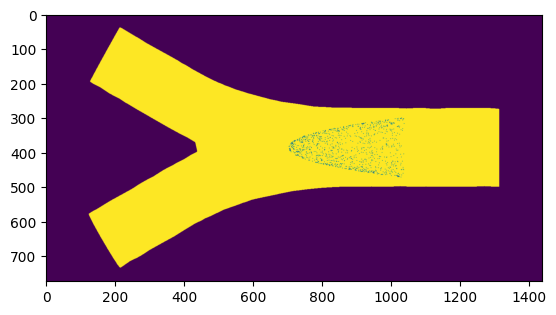

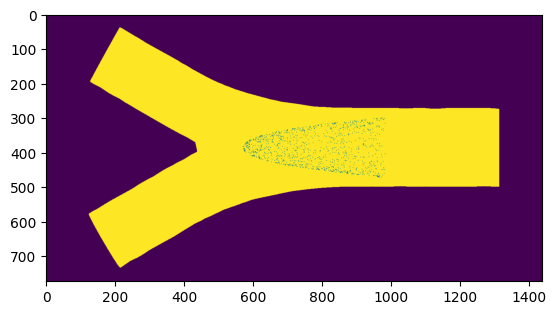

In [17]:

i = 5


fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(frames[i])
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.imshow(frames[i+1])
fig.show()

In [18]:
winsize = 32        # pixels, interrogation window size in frame A
searchsize = 38     # pixels, search area size in frame B
overlap = 17        # pixels, 50% overlap
dt = 0.02           # sec, time interval between the two frames



u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frames[i].astype(np.int32),
    frames[i+1].astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

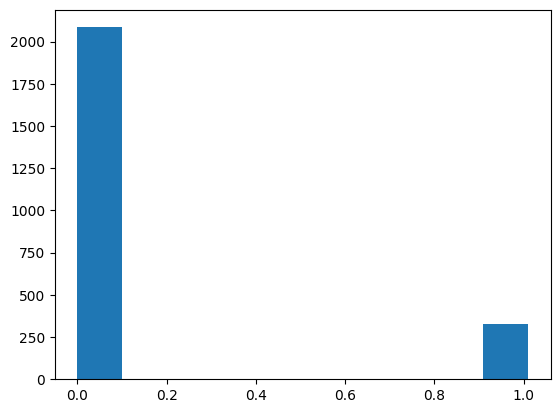

In [19]:
plt.hist(sig2noise.flatten())
plt.show()

In [20]:
x, y = pyprocess.get_coordinates(
    image_size=frames[0].shape,
    search_area_size=searchsize,
    overlap=overlap,
)



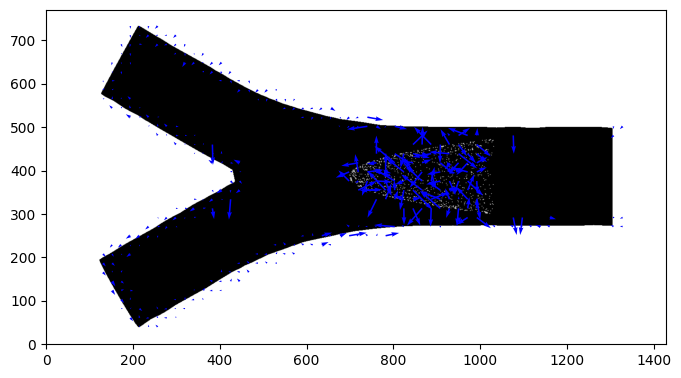

0005


In [21]:
tools.save('exp1_001.txt' , x, y, u0, v0)
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    filename=pathlib.Path('exp1_001.txt'),
    ax=ax, 
    #scaling_factor=96.52,
    #scale=50, # scale defines here the arrow length
    #width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= os.path.join(path, ex, ex+f".{i:04d}.tiff")
);
str_i = f"{i:04d}"
print(str_i)